Data Source:  http://insideairbnb.com/get-the-data.html

## 1. Import Boilerplate code

In [4]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib as mpl
import mpl_toolkits
from datetime import datetime
import geopandas

In [5]:
import folium
import mpl_toolkits
import nltk
import textblob

In [7]:
pd.set_option('display.max_columns', None)

## 2. Import Data and review the top 5 fields

In [8]:
data_folder='../../data/airbnb/'
#files: calendar.csv.gz  listings_summary.csv    reviews.csv.gz
# listings.csv     neighbourhoods.csv      reviews_summary.csv
# listings.csv.gz  neighbourhoods.geojson

data_calendar = pd.read_csv(data_folder+"calendar.csv")
data_listings_summary=pd.read_csv(data_folder+"listings_summary.csv")
data_reviews = pd.read_csv(data_folder+"reviews.csv.gz")
data_listings = pd.read_csv(data_folder+"listings.csv",low_memory=False, parse_dates=True)
data_neighbourhoods= pd.read_csv(data_folder+"neighbourhoods.csv", low_memory=False)
data_review_summary=pd.read_csv(data_folder+"reviews_summary.csv")
data_neighbourhoods_geo=pd.read_json(data_folder+"neighbourhoods.geojson")

In [9]:
data_listings.neighborhood_overview.head()

0    Not even 10 minutes by metro from Victoria Sta...
1                                                  NaN
2    Finsbury Park is a friendly melting pot commun...
3    Very easy to get to all the main sites. The tu...
4    A quick guide or a run through about the area ...
Name: neighborhood_overview, dtype: object

## 3. Clean Data
- Remove non-GB based listings
- Remove listings with per day price is greater than £x.00 i.e. any artificial skews in the data
- Remove listings with price, bed etc set as £0
- Remove listings where reviews are in a non-english language

In [10]:
data_listings[data_listings.country_code!="GB"].head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
41783,23325697,https://www.airbnb.com/rooms/23325697,20191105115249,2019-11-06,Can torres,M7 minutes to Ibiza Town,NaN,M7 minutes to Ibiza Town,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/b8eef05a-1...,NaN,85507414,https://www.airbnb.com/users/show/85507414,Lionel,2016-07-23,"England, United Kingdom",NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/08754...,https://a0.muscache.com/im/pictures/user/08754...,NaN,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,f,"Ibiza, Baleares, Spain",LB of Wandsworth,Wandsworth,NaN,Ibiza,Baleares,07814,London,"Ibiza, Spain",ES,Spain,51.47145,-0.14136,f,Villa,Entire home/apt,8,5.5,5.0,6.0,Real Bed,"{TV,""Cable TV"",Wifi,""Air conditioning"",Pool,Ki...",NaN,$948.00,NaN,NaN,NaN,NaN,1,$0.00,8,59,8,8,59,59,8.0,59.0,18 months ago,t,23,53,83,173,2019-11-06,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,NaN,NaN,t,f,flexible,f,f,1,1,0,0,NaN
57006,30320965,https://www.airbnb.com/rooms/30320965,20191105115249,2019-11-05,"Chambre idéal pour couple, 10min à pied de Camden",Chambre lumineuse très bien situé à 7min à pie...,L’appartement est calme et très bien situé pou...,Chambre lumineuse très bien situé à 7min à pie...,none,Vous trouverez une station de métro (Kentish T...,NaN,NaN,Vous disposerez en plus de la chambre d’une cu...,Je suis disponible par sms ou téléphone dès qu...,Entretenir la chambre et les pièces communes a...,NaN,NaN,https://a0.muscache.com/im/pictures/feb1380b-e...,NaN,63917372,https://www.airbnb.com/users/show/63917372,Fanny,2016-03-21,"Biarritz, Nouvelle-Aquitaine, France",NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/54f77...,https://a0.muscache.com/im/pictures/user/54f77...,NaN,1.0,1.0,"['email', 'phone']",t,f,"Londres, France",LB of Camden,Camden,NaN,Londres,NaN,NW5 4RG,London,"Londres, France",FR,France,51.54894,-0.14564,f,Condominium,Private room,2,1.0,1.0,1.0,Real Bed,"{Wifi,Kitchen,Heating,Washer,""Smoke detector"",...",NaN,$43.00,NaN,NaN,NaN,NaN,1,$0.00,1,30,1,1,30,30,1.0,30.0,10 months ago,t,0,0,0,0,2019-11-05,1,1,2019-01-03,2019-01-03,100.0,10.0,10.0,10.0,10.0,10.0,8.0,t,NaN,"{""translation missing: en.occupancy.taxes.juri...",f,f,flexible,f,f,1,0,1,0,0.1
61178,32394504,https://www.airbnb.com/rooms/32394504,201

In [11]:
data_listings.drop(data_listings[data_listings.country_code!="GB"].index.values,axis=0,inplace=True)

### 3a. Map in numerical price from summary file

In [12]:
data_listings['price2'] = data_listings['id'].map(data_listings_summary.set_index('id')['price'])

In [13]:
#data_listings.isnull().sum()[data_listings.isnull().sum()>0]

### 3b. Drop scrape_id,l isting_url,interaction,notes,thumbnail_url,medium_url,picture_url,host_url,host_name,host_response_time,host_response_rate,host_acceptance_rate,host_thumbnail_url,host_picture_url,host_listings_count,host_verifications,host_identity_verified

In [14]:
data_listings.drop(["scrape_id","listing_url","interaction","notes","thumbnail_url","medium_url","picture_url","host_url","host_name","host_response_time","host_response_rate","host_acceptance_rate","host_thumbnail_url","host_picture_url","host_listings_count","host_verifications","host_identity_verified"],axis=1,inplace=True)
data_listings.drop(["first_review","license","jurisdiction_names","requires_license","require_guest_phone_verification"],axis=1,inplace=True)
data_listings.drop(["xl_picture_url","host_location","market","smart_location","country_code","country","is_location_exact"],axis=1,inplace=True)
data_listings.drop(["host_neighbourhood","street","square_feet","weekly_price","monthly_price","security_deposit","cleaning_fee","guests_included","review_scores_accuracy","review_scores_checkin","review_scores_communication","review_scores_value"],axis=1,inplace=True)
data_listings.drop(["neighbourhood_group_cleansed","minimum_nights_avg_ntm","maximum_nights_avg_ntm","calendar_updated","calculated_host_listings_count","calculated_host_listings_count_entire_homes","calculated_host_listings_count_private_rooms","calculated_host_listings_count_shared_rooms"],axis=1,inplace=True)
data_listings.drop(["transit","zipcode","city","state"],axis=1,inplace=True)
data_listings.drop(['maximum_nights','minimum_minimum_nights', 'maximum_minimum_nights','minimum_maximum_nights', 'maximum_maximum_nights'],axis=1,inplace=True)
data_listings.drop(["bathrooms","bedrooms","neighbourhood",'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped',"is_business_travel_ready"],axis=1,inplace=True)
data_listings.drop(["has_availability","extra_people"],axis=1,inplace=True)


In [15]:
data_listings.drop(["number_of_reviews_ltm"],axis=1,inplace=True)

In [16]:
data_listings.columns

Index(['id', 'last_scraped', 'name', 'summary', 'space', 'description',
       'experiences_offered', 'neighborhood_overview', 'access', 'house_rules',
       'host_id', 'host_since', 'host_about', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'beds', 'bed_type', 'amenities', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_location', 'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'reviews_per_month', 'price2'],
      dtype='object')

### 3c. Dropping meaningful variables with null and or 0 values

In [17]:
data_listings.drop(data_listings[data_listings.beds==0].index.values,axis=0, inplace=True)

In [18]:
data_listings.drop(data_listings[data_listings.beds.isnull()].index.values,axis=0, inplace=True)

In [19]:
#data_listings.drop(data_listings[data_listings.neighbourhood.isnull()].index.values,axis=0, inplace=True)

In [20]:
data_listings.drop(data_listings[data_listings.review_scores_rating.isnull()].index.values,axis=0, inplace=True)
data_listings.drop(data_listings[data_listings.review_scores_cleanliness.isnull()].index.values,axis=0, inplace=True)
data_listings.drop(data_listings[data_listings.review_scores_location.isnull()].index.values,axis=0, inplace=True)
data_listings.drop(data_listings[data_listings.host_is_superhost.isnull()].index.values,axis=0, inplace=True)
data_listings.drop(data_listings[data_listings.host_has_profile_pic.isnull()].index.values,axis=0, inplace=True)
data_listings.drop(data_listings[data_listings.property_type=="Parking Space"].index.values,axis=0, inplace=True)
data_listings.drop(data_listings[data_listings.price2==10000].index.values,inplace=True)
data_listings.drop(data_listings[data_listings.price2>250].index.values,inplace=True)
data_listings.drop(data_listings[data_listings.price2==0].index.values,inplace=True)

In [21]:
data_listings.drop(data_listings[data_listings.reviews_per_month.isnull()].index.values,axis=0, inplace=True)

### 3d. Identify the numerical, categorical and qualitative variables

In [22]:
#numeric_fields

In [23]:
# data_listings.dtypes[data_listings.dtypes!=object].index.values
# text_fields=data_listings.dtypes[data_listings.dtypes==object].index.values
# numeric_fields=data_listings.dtypes[data_listings.dtypes!=object].index.values
# np.delete(numeric_fields,[0,2],)
# data_listings[numeric_fields].describe()
# ar=np.argwhere(numeric_fields == ("price2"))
# car=np.argwhere(numeric_fields == ("price_per_guest"))
# bar=np.argwhere(numeric_fields == ("pppg_prop"))
# dar=np.argwhere(numeric_fields == ("latitude"))
# var=np.argwhere(numeric_fields == ("longitude"))
# gar=np.argwhere(numeric_fields == ("id"))
# far=np.argwhere(numeric_fields == ("host_id"))
# xar=np.argwhere(numeric_fields == ("host_is_superhost"))
# yar=np.argwhere(numeric_fields == ("host_has_profile_pic"))
# zar=np.argwhere(numeric_fields == ("require_guest_profile_picture"))
# ear=np.argwhere(numeric_fields == ("dist_lat"))
# iar=np.argwhere(numeric_fields == ("dist_long"))

# numeric_fields=np.delete(numeric_fields,[ar,bar,car,var,dar,gar,far,xar,yar,zar,ear,iar])

### 3e. Introduce price per guest variable

In [24]:
data_listings['price_per_guest']=data_listings['price2']/data_listings['accommodates']

In [25]:
data_listings.price_per_guest.max()

250.0

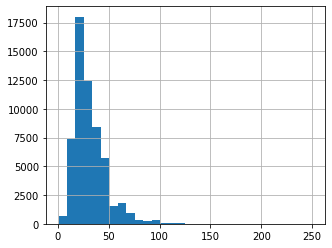

In [26]:
data_listings.price_per_guest.hist(bins=30,figsize=(5,4))

In [27]:
## Let's check for skew and kurtosis
print("Skewness before log transform: ", data_listings.price_per_guest.skew())
print("Kurtosis before log transform: ",data_listings.price_per_guest.kurt())


Skewness before log transform:  2.2195241380417405
Kurtosis before log transform:  11.116117148856201


Skewness before log transform:  -0.0488371620279598
Kurtosis before log transform:  1.0926223081728863


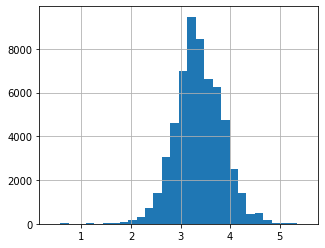

In [28]:
#One can argue this is too much kurtosis though a fairly acceptable level of skew. Let's try and take an exponential attempt and an attempt with normalising y.
Y = np.log1p(data_listings.price_per_guest)
print("Skewness before log transform: ", Y.skew())
print("Kurtosis before log transform: ",Y.kurt())
#Let's visulaise the histogram
Y.hist(bins=30,figsize=(5,4));

In [29]:
#Let's normalise our Y
data_listings.price_per_guest = np.log1p(data_listings.price_per_guest)


### 3f. Factorize boolean variables and identify categorical variables

In [30]:
#data_listings.host_is_superhost.head()

In [31]:
# codes,uniques=data_listings.host_is_superhost.factorize()
# data_listings.host_is_superhost=codes
# data_listings.plot.scatter("host_is_superhost","price2");

In [32]:
#data_listings.host_is_superhost.head()

In [33]:
#data_listings.host_has_profile_pic.head()

In [34]:
# codes,uniques=data_listings.host_has_profile_pic.factorize()
# data_listings.host_has_profile_pic=codes
#data_listings.plot.scatter("number_of_reviews","price2")

In [35]:
# codes,uniques=data_listings.require_guest_profile_picture.factorize()
# data_listings.require_guest_profile_picture=codes
# data_listings.plot.scatter("require_guest_profile_picture","price2");


In [36]:
# codes,uniques=data_listings.instant_bookable.factorize()
# data_listings.instant_bookable=codes
# data_listings.plot.scatter("instant_bookable","price2")

In [37]:
len(data_listings.property_type.unique())

36

### 3g. Visualise relationships between numerical variables to ensure no unnecessary variables are retained

In [38]:
#from the above, we can see little relation between minimum_nights and host_total_listings_count and we can delete them
data_listings.drop(["minimum_nights","host_total_listings_count"],axis=1,inplace=True)

### 3e. Transform neighbourhood and geographical attributes 
#### The latitude and longitude variables reflect a "quadratic relation with price per guest". This in line with our expectation of central London house prices. We will explore this relationship visually and apply a transformation to make it consummable in linear regression.

In [39]:
#zonation data
Zone1=["City of London", "Camden", "Hackney", "Islington", "Kensington and Chelsea", "Southwark", "Westminster"]
Zone2=["Greenwich", "Hackney", "Hammersmith and Fulham", "Lewisham", "Tower Hamlets", "Wandsworth","Lambeth"]
Zone3=["Barnet", "Brent", "Bromley", "Croydon", "Ealing","Hounslow", "Newham", "Richmond upon Thames", "Waltham Forest"]
Zone4=["Barking and Dagenham", "Bexley","Enfield", "Haringey","Merton", "Newham", "Redbridge", "Sutton","Kingston upon Thames"]
Zone5=["Harrow", "Hillingdon","Havering"]


In [40]:
#count=1
zones= [Zone1,Zone2,Zone3,Zone4,Zone5]
mapping=dict()
for bo in data_listings.neighbourhood_cleansed.unique():
    if bo in (Zone1 + Zone2 + Zone3 + Zone4 + Zone5):
        for count,zns in enumerate(zones):
            if bo in zns:
                mapping[bo]="Zone" + str(count+1)
    else:
        print(bo)
            
            

In [41]:
mapping
def zonify(neighbourhood_cleansed):
    return(mapping.get(neighbourhood_cleansed))

In [42]:
data_listings["Fare_Zone_Rough"]=data_listings['neighbourhood_cleansed'].apply(zonify)

#### We can see that the 50th percentile is higher for more central zones but all have large outliers.

### Fit a linear model recursively. Then dummify the categorical variables


In [43]:
#Let's dummify some categories e.g Property Type and Rough Fare Zone
data_listings.columns

Index(['id', 'last_scraped', 'name', 'summary', 'space', 'description',
       'experiences_offered', 'neighborhood_overview', 'access', 'house_rules',
       'host_id', 'host_since', 'host_about', 'host_is_superhost',
       'host_has_profile_pic', 'neighbourhood_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'beds',
       'bed_type', 'amenities', 'price', 'number_of_reviews', 'last_review',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_location', 'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'reviews_per_month', 'price2',
       'price_per_guest', 'Fare_Zone_Rough'],
      dtype='object')

In [44]:
cates=data_listings[['Fare_Zone_Rough','property_type','cancellation_policy']]

In [45]:
data_listings=pd.concat([data_listings,pd.get_dummies(data=cates, drop_first=True)], axis=1)

In [46]:
cates2=data_listings['bed_type']
data_listings=pd.concat([data_listings,pd.get_dummies(data=cates2, drop_first=True)], axis=1)

In [47]:
cates3=data_listings['room_type']
data_listings=pd.concat([data_listings,pd.get_dummies(data=cates3, drop_first=True)], axis=1)

In [48]:
for field in ['require_guest_profile_picture','instant_bookable','host_is_superhost','host_has_profile_pic']:
    data_listings[field]=data_listings[field].map({'t':(field +' true'),'f':(field +' false')})

In [49]:
data_listings[['require_guest_profile_picture','instant_bookable','host_is_superhost','host_has_profile_pic']]
cates1=['require_guest_profile_picture','instant_bookable','host_is_superhost','host_has_profile_pic']
data_listings=pd.concat([data_listings,pd.get_dummies(data=data_listings[cates1], drop_first=True)], axis=1)
data_listings.head()

,id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,access,house_rules,host_id,host_since,host_about,host_is_superhost,host_has_profile_pic,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,beds,bed_type,amenities,price,number_of_reviews,last_review,review_scores_rating,review_scores_cleanliness,review_scores_location,instant_bookable,cancellation_policy,require_guest_profile_picture,reviews_per_month,price2,price_per_guest,Fare_Zone_Rough,Fare_Zone_Rough_Zone2,Fare_Zone_Rough_Zone3,Fare_Zone_Rough_Zone4,Fare_Zone_Rough_Zone5,property_type_Apartment,property_type_Barn,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Casa particular (Cuba),property_type_Chalet,property_type_Condominium,property_type_Cottage,property_type_Earth house,property_type_Farm stay,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Houseboat,property_type_Hut,property_type_Island,property_type_Lighthouse,property_type_Loft,property_type_Minsu (Taiwan),property_type_Nature lodge,property_type_Other,property_type_Ryokan (Japan),property_type_Serviced apartment,property_type_Tent,property_type_Tiny house,property_type_Townhouse,property_type_Treehouse,property_type_Villa,property_type_Yurt,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,Couch,Futon,Pull-out Sofa,Real Bed,Hotel room,Private room,Shared room,require_guest_profile_picture_require_guest_profile_picture true,instant_bookable_instant_bookable true,host_is_superhost_host_is_superhost true,host_has_profile_pic_host_has_profile_pic true
0,11551,2019-11-06,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,"Amenities Bedding: 1 Double bed, 1 living room...",Unlike most rental apartments out there my fla...,family,Not even 10 minutes by metro from Victoria Sta...,Guest will have access to the entire apartment,No Smoking (very strict) No pets are allowed i...,43039,2009-10-03,"Hello, I'm a friendly Italian man with a very ...",host_is_superhost true,host_has_profile_pic true,Lambeth,51.46225,-0.11732,Apartment,Entire home/apt,4,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Paid par...",$88.00,185,2019-09-15,92.0,9.0,9.0,instant_bookable true,strict_14_with_grace_period,require_guest_profile_picture false,1.58,88,3.135494,Zone2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,1
3,38407,2019-11-06,Canary Wharf Immaculate Apt for 2,"The bright, light and stylish apartment in Can...","An entire bright, light and stylish apartment....","The bright, light and stylish apartment in Can...",none,Very easy to get to all the main sites. The tu...,This is a quiet self-contained apartment with ...,Respect both check-in and check-out times.,164566,2010-07-12,"A entire bright, light and stylish apartment. ...",host_is_superhost false,host_has_profile_pic true,Tower Hamlets,51.49995,-0.02624,Apartment,Entire home/apt,2,1.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,H...",$79.00,137,2017-04-21,95.0,10.0,9.0,instant_bookable true,strict_14_with_grace_period,require_guest_profile_picture false,1.23,79,3.701302,Zone2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1
4,90700,2019-11-06,Sunny Notting Hill flat & terrace,This is a home not a hotel - for the cost gues...,This charming 1 bedroom with en-suite bathroom...,This is a home not a hotel - for the cost gues...,none,A quick guide or a run through about the area ...,The whole place is for our guests to enjoy.,Full rules will be provided on arrival but the...,491286,2011-04-07,I am a curator working for a gallery 

In [50]:
pd.set_option('display.max_columns', None)

In [51]:
data_listings.drop(['Fare_Zone_Rough','property_type','cancellation_policy'],axis=1,inplace=True)

In [52]:
data_listings.drop(['require_guest_profile_picture','instant_bookable','host_is_superhost','host_has_profile_pic'],axis=1,inplace=True)

In [53]:
data_listings.dropna(inplace=True)

In [90]:
X=data_listings[['beds','number_of_reviews',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_location', 'reviews_per_month','Fare_Zone_Rough_Zone3', 'Fare_Zone_Rough_Zone4',
       'Fare_Zone_Rough_Zone5', 'property_type_Apartment',
       'property_type_Barn', 'property_type_Bed and breakfast',
       'property_type_Boat', 'property_type_Boutique hotel',
       'property_type_Bungalow', 'property_type_Cabin',
       'property_type_Camper/RV', 'property_type_Casa particular (Cuba)',
       'property_type_Chalet', 'property_type_Condominium',
       'property_type_Cottage', 'property_type_Earth house',
       'property_type_Farm stay', 'property_type_Guest suite',
       'property_type_Guesthouse', 'property_type_Hostel',
       'property_type_Hotel', 'property_type_House', 'property_type_Houseboat',
       'property_type_Hut', 'property_type_Island', 'property_type_Lighthouse',
       'property_type_Loft', 'property_type_Minsu (Taiwan)',
       'property_type_Nature lodge', 'property_type_Other',
       'property_type_Ryokan (Japan)', 'property_type_Serviced apartment',
       'property_type_Tent', 'property_type_Tiny house',
       'property_type_Townhouse', 'property_type_Treehouse',
       'property_type_Villa', 'property_type_Yurt',
       'require_guest_profile_picture_require_guest_profile_picture true',
       'instant_bookable_instant_bookable true',
       'host_is_superhost_host_is_superhost true',
       'host_has_profile_pic_host_has_profile_pic true','Couch', 'Futon',
       'Pull-out Sofa', 'Real Bed','Hotel room', 'Private room',
       'Shared room']]

In [91]:
#split the data into simple train_test_split
Y=data_listings.price_per_guest
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state = 40)

In [92]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
treereg= DecisionTreeRegressor(random_state=43)

In [93]:
treereg

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=43, splitter='best')

In [94]:
scores = cross_val_score(treereg,X_train,Y_train,cv=14,scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

0.5451533688400007

In [95]:
max_depth_range = list(range(1,20))
RMSE_scores= []

for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X_train, Y_train, cv=14, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))


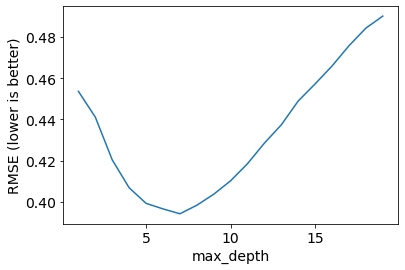

In [96]:
mpl.pyplot.plot(max_depth_range, RMSE_scores);
mpl.pyplot.xlabel('max_depth');
mpl.pyplot.ylabel('RMSE (lower is better)');

In [97]:
np.argmin(RMSE_scores)

6

In [98]:
#max depth is 6, let's retune the max depth
treereg = DecisionTreeRegressor(max_depth=6, random_state=1)
treereg.fit(X_train, Y_train)

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=1, splitter='best')

In [99]:
feature_importance =pd.DataFrame({'feature':X_train, 'importance':treereg.feature_importances_}).sort_values(by='importance',ascending=False)

In [100]:
feature_importance[feature_importance.importance>0]

,feature,importance
0,"(b, e, d, s)",0.271487
53,"(P, r, i, v, a, t, e, , r, o, o, m)",0.251612
4,"(r, e, v, i, e, w, _, s, c, o, r, e, s, _, l, ...",0.203119
27,"(p, r, o, p, e, r, t, y, _, t, y, p, e, _, H, ...",0.080578
5,"(r, e, v, i, e, w, s, _, p, e, r, _, m, o, n, ...",0.050584
2,"(r, e, v, i, e, w, _, s, c, o, r, e, s, _, r, ...",0.032989
1,"(n, u, m, b, e, r, _, o, f, _, r, e, v, i, e, ...",0.029430
6,"(F, a, r, e, _, Z, o, n, e, _, R, o, u, g, h, ...",0.025261
7,"(F, a, r, e, _, Z, o, n, e, _, R, o, u, g, h, ...",0.023272
54,"(S, h, a, r, e, d, , r, o, o, m)",0.012927


In [101]:
scores = cross_val_score(treereg, X_train, Y_train, cv=14, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

0.39662927509515217

In [102]:
%matplotlib inline
mpl.pyplot.rcParams['figure.figsize'] = (6, 4)
mpl.pyplot.rcParams['font.size'] = 14

In [103]:
Y_train.describe()

count    12912.000000
mean         3.357621
std          0.468328
min          0.693147
25%          3.044522
50%          3.349904
75%          3.650658
max          5.525453
Name: price_per_guest, dtype: float64

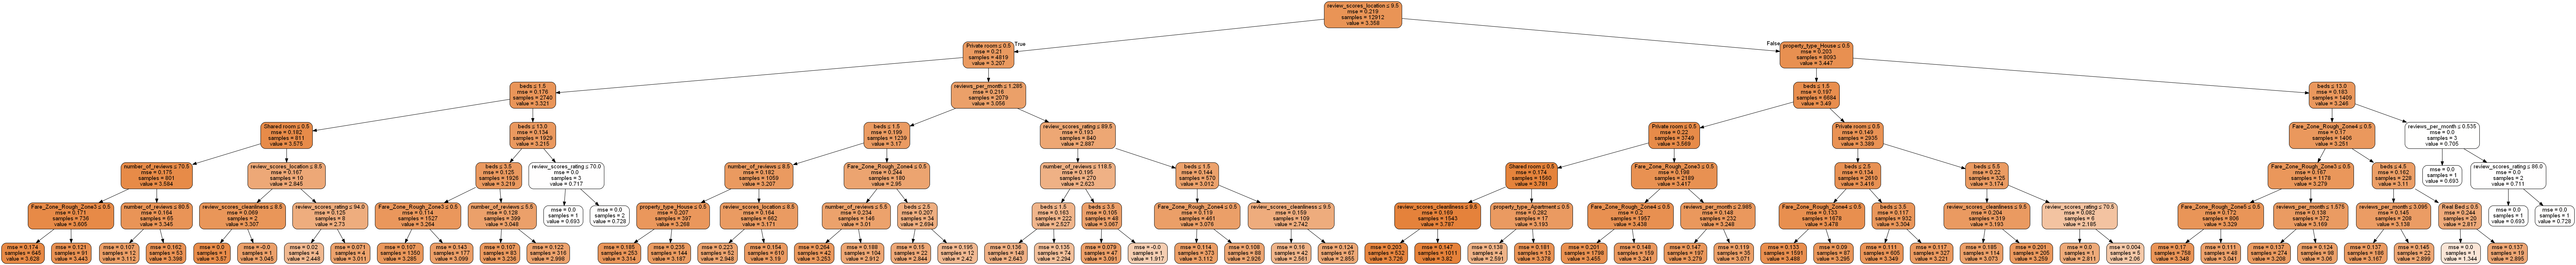

In [104]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
import pydotplus
from IPython.display import Image  
dot_data = StringIO()
export_graphviz(treereg, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names=X_train.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('vehicle_tree.png')
Image(graph.create_png())


In [105]:
from sklearn.metrics import mean_squared_error
Y_pred=treereg.predict(X_test)
np.sqrt(mean_squared_error(Y_test, Y_pred))

0.3914871263546632

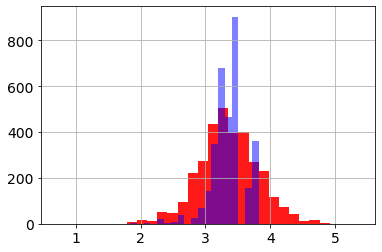

In [106]:
Y_test.hist(bins=30, color ='red', alpha=0.9)
mpl.pyplot.hist(Y_pred,bins=30, color ='blue', alpha=0.5);


In [107]:
dummy=pd.concat([X_test,Y_test],axis=1)

In [108]:
error=dummy['price_per_guest']-Y_pred

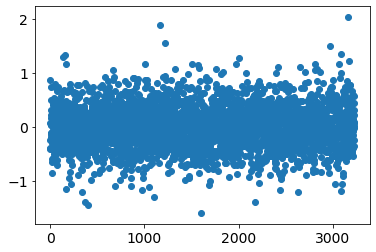

In [109]:
x=range(3229)
mpl.pyplot.scatter(x,error)

In [110]:
Y_predict =pd.Series(Y_pred)

In [111]:
from sklearn.utils.multiclass import type_of_target
type_of_target(Y)

'continuous'

In [112]:
from sklearn.metrics import r2_score
print ('R2: ', r2_score(Y_test,Y_pred))

R2:  0.280380019399908


In [113]:
#let's try a more powerful algorithm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict


In [114]:
model = DecisionTreeRegressor(random_state=42)
#Grid Search
PARAMETERS = {'max_depth':[1,2,3,4,5,6],
              'max_leaf_nodes':[5,6,7,8,9,10], 
              'min_samples_leaf':[3,4,5]
             }

gs = GridSearchCV(model, PARAMETERS,cv=5)
gs.fit(X_train, Y_train)

best_model = gs.best_estimator_
print(best_model)

scores = cross_val_score(best_model, X_train, Y_train, cv=5, scoring='neg_mean_squared_error')
print(-scores)
print('Avg: ', np.mean(-scores))

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
                      max_leaf_nodes=10, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')
[0.16521861 0.16889415 0.16183872 0.17799287 0.17048797]
Avg:  0.16888646473417235


In [115]:
gs_results=pd.DataFrame(gs.cv_results_)[['params','mean_test_score']]

In [116]:
import ast
gs_results['max_depth']=np.nan
gs_results['max_leaf_nodes']=np.nan
gs_results['min_samples_leaf']=np.nan
gs_results
for ind in range((gs_results).shape[0]):
    atts_dict=(gs_results.loc[ind]['params'])
    gs_results['max_depth'].iloc[ind]=atts_dict.get('max_depth')
    gs_results['max_leaf_nodes'].iloc[ind]=atts_dict.get('max_leaf_nodes')
    gs_results['min_samples_leaf'].loc[ind]=atts_dict.get('min_samples_leaf')

C:\Users\isimr\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [117]:
gs_results.iloc[ind]['params']
gs_results.mean_test_score.argmin()

C:\Users\isimr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  


0

In [121]:
gs_results.drop('params',axis=1).groupby(['min_samples_leaf'])
three=gs_results[gs_results.min_samples_leaf==3]
four=gs_results[gs_results.min_samples_leaf==4]
five=gs_results[gs_results.min_samples_leaf==5]
three.mean_test_score.min()

0.061330481059778626

In [122]:
print(four.mean_test_score.min())
print(five.mean_test_score.min())

0.061330481059778626
0.061330481059778626


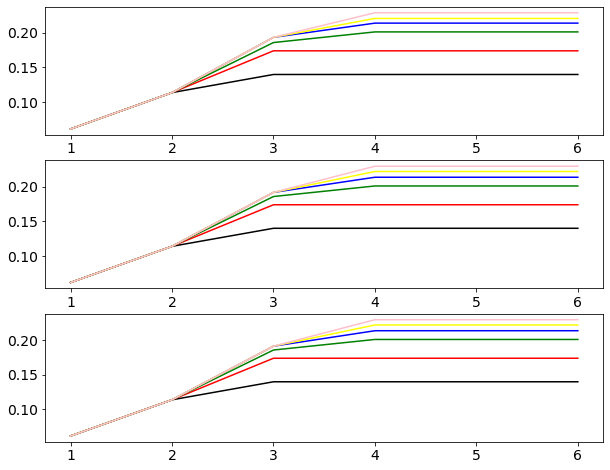

In [119]:
fig,ax= mpl.pyplot.subplots(3, figsize=(10,8))
max_leaf_nodes_unique=gs_results.max_leaf_nodes.unique()
colors=['red','green','blue','yellow','pink','black']
for leaf in max_leaf_nodes_unique:
    ax[0].plot(three[three.max_leaf_nodes==leaf].max_depth,three[three.max_leaf_nodes==leaf].mean_test_score,color=colors[int(leaf)-6]);
    ax[1].plot(four[four.max_leaf_nodes==leaf].max_depth,four[four.max_leaf_nodes==leaf].mean_test_score,color=colors[int(leaf)-6]);
    ax[2].plot(five[five.max_leaf_nodes==leaf].max_depth,five[five.max_leaf_nodes==leaf].mean_test_score,color=colors[int(leaf)-6]);

In [120]:
from sklearn.ensemble import RandomForestRegressor

In [128]:
#fit a randomforest for feature bagging
rfreg = RandomForestRegressor(n_estimators=150, max_features=5, oob_score=True, random_state=1)
rfreg.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=True, random_state=1, verbose=0,
                      warm_start=False)

In [130]:
pd.DataFrame({'feature':X_train.columns, 'importance':rfreg.feature_importances_}).sort_values(by='importance')

,feature,importance
38,property_type_Tent,0.000000
36,property_type_Ryokan (Japan),0.000000
33,property_type_Minsu (Taiwan),0.000000
31,property_type_Lighthouse,0.000000
30,property_type_Island,0.000000
22,property_type_Farm stay,0.000000
17,property_type_Casa particular (Cuba),0.000000
10,property_type_Barn,0.000000
34,property_type_Nature lodge,0.000006
43,property_type_Yurt,0.000010


In [132]:
print((rfreg.oob_score_))

# Find the average RMSE.
scores = cross_val_score(rfreg, X_train, Y_train, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

0.26241716827949646


0.4005100619099811

In [135]:
np.sqrt(mean_squared_error(Y_test, rfreg.predict(X_test)))

0.39073675890682075

In [136]:
from sklearn.metrics import r2_score
print ('R2: ', r2_score(Y_test,rfreg.predict(X_test)))

R2:  0.2831359818817798


In [140]:
estimator_range = list(range(10, 1000, 10))

# List to store the average RMSE for each value of n_estimators:
RMSE_scores = []

# Use five-fold cross-validation with each value of n_estimators (Warning: Slow!).
for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator, random_state=22)
    MSE_scores = cross_val_score(rfreg, X_train, Y_train, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

KeyboardInterrupt: 

In [ ]:

mpl.pyplot.plot(estimator_range, RMSE_scores);

mpl.pyplot.xlabel('n_estimators');
mpl.pyplot.ylabel('RMSE (lower is better)');

In [141]:
rfreg

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=780,
                      n_jobs=None, oob_score=False, random_state=22, verbose=0,
                      warm_start=False)

In [142]:
%store rfreg

Stored 'rfreg' (RandomForestRegressor)


In [143]:
X_train.index

Int64Index([32418, 20951, 24072, 47668, 32218, 69969, 54962, 13045, 22961,
            31052,
            ...
            17461, 44725, 81525, 15509, 24517, 43059, 64140, 62983, 64696,
            44936],
           dtype='int64', length=12912)